In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
cell_df = pd.read_csv('cell_samples.csv')
cell_df.head(10)

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


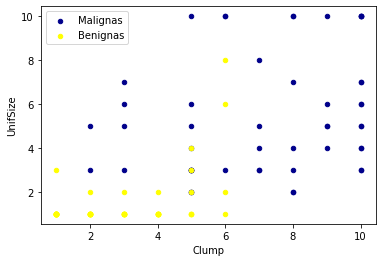

In [3]:
# Hacemos una grafica exploratoria
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='Malignas');
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='Benignas', ax=ax);
plt.show()

In [4]:
# Ver tipos de datos de las columnas
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

Parece que la columna BareNuc incluye algunos valores que no son numéricos. Podemos eliminar esas filas:

In [5]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')

In [6]:
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

Queremos que el modelo prediga el valor de la columna Class (si es benigno (=2), si es maligno (=4)). Como este campo puede tener uno de dos valores posibles, necesitaremos cambiar su nivel de medición para reflejar eso.

In [7]:
caracteristicas_df = cell_df[['Clump','UnifSize','UnifShape','MargAdh','SingEpiSize','BareNuc','BlandChrom','NormNucl','Mit']]
X= np.asarray(caracteristicas_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

In [8]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y[0:5]

array([2, 2, 2, 2, 2])

Train/Test dataset
Ahora, dividimos el set de datos en entrenamiento y prueba:

In [9]:
#train_test_split siempre se va usar asi
X_entranamiento, X_prueba, Y_entrenamiento, Y_prueba  =  train_test_split(X,y, test_size=0.2, random_state=4)
print('Datos de entrenamiento', X_entranamiento.shape, Y_entrenamiento.shape)
print('Datos de prueba', X_prueba.shape, Y_prueba.shape)

Datos de entrenamiento (546, 9) (546,)
Datos de prueba (137, 9) (137,)


Modelado (SVM con aprendizaje Scikit)
El algoritmo SVM ofrece elegir funciones para realizar su procesamiento. Básicamente, mapear los datos en un espacio dimensional más alto se llama kernelling. La función matemática utilizada para la transformación se conoce como la función kernel, y puede ser de distintos tipos, a ser:

Lineal
Polimonial
Función de base Radial (RBF)
Sigmoide
Cada una de estas funciones tiene sus características, pros y contras y su ecuación, pero como no hay una forma sencilla de saber la función que mejor funcionaría, elegimos utilizar diferentes funciones y comparar los resultados. Utilicemos la función por omisión, RBF (Función Basada en Radio) para este lab.

In [10]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_entranamiento,Y_entrenamiento) # creamos el modelo y estamos enseñandole al algoritm

SVC()

In [11]:
#Vamos hacer las prediccion
yhat= clf.predict(X_prueba)
yhat[0:5]

array([2, 4, 2, 4, 2])

### Evaluación

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [13]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matriz')
    else:
        print('Matriz de confusión, sin normalización')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment='center',
        color='white'
        if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('Etiqueta True')
    plt.xlabel('Etiqueta predecida')

In [14]:
Y_prueba

array([2, 4, 2, 4, 2, 2, 2, 2, 4, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 4, 2,
       4, 4, 2, 2, 2, 2, 4, 4, 4, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4,
       4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 2, 4,
       4, 2, 2, 2, 4, 4, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 4,
       2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 4, 2, 4, 2, 2, 4, 2, 4, 2, 2, 4,
       2, 2, 4, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 2, 2, 4, 2, 2, 4, 2, 4, 2,
       2, 2, 2, 2, 4])

In [15]:
yhat

array([2, 4, 2, 4, 2, 2, 2, 2, 4, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 4, 2,
       4, 4, 4, 4, 2, 2, 4, 4, 4, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4,
       4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 4, 4,
       4, 2, 2, 2, 4, 4, 2, 2, 2, 4, 2, 2, 4, 4, 2, 2, 2, 2, 4, 4, 2, 4,
       2, 2, 4, 4, 2, 2, 2, 4, 2, 2, 2, 4, 2, 4, 2, 2, 4, 2, 4, 2, 2, 4,
       2, 2, 4, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 2, 2, 4, 2, 2, 4, 2, 4, 2,
       2, 2, 2, 2, 4])

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Matriz de confusión, sin normalización
[[85  5]
 [ 0 47]]


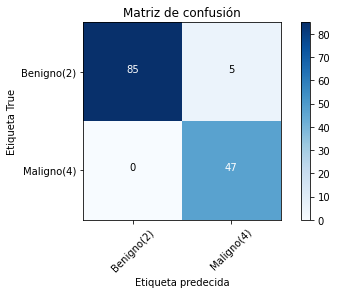

In [16]:
# Computar la matriz de confusión
cnf_matrix = confusion_matrix(Y_prueba, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(Y_prueba, yhat))

# Trazar matriz de confusión no normalizada
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benigno(2)','Maligno(4)'],normalize= False,  title='Matriz de confusión')

Se puede utilizar facilmente el f1_score de la librería sklearn:

In [17]:
from sklearn.metrics import f1_score
f1_score(Y_prueba, yhat, average='weighted')

0.9639038982104676

## 96 % de prediciones correctas!!!